In [9]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# Conflict and Commuting Zones

In [31]:
acled = pd.read_csv("../../data/conflict/Niger_conflict_data.csv")

In [35]:
acled["event_date"] = acled["event_date"].apply(
    lambda x: pd.to_datetime(x, format="YYYY-MM-DD")
)

In [49]:
acled["nrEvents"] = 1

In [50]:
acled_yearly = (
    acled.groupby(
        [
            pd.Grouper(key="event_date", freq="YS"),
            "latitude",
            "longitude",
            "actor1",
            "actor2",
            "country",
            "admin1",
            "admin2",
            "event_type",
            "sub_event_type",
        ]
    )
    .sum()
    .reset_index()
)

In [4]:
commuting_zones_niger = gpd.read_file(
    "../../data/movement/meta/commuting_zones/commuting_zones_niger.json"
)

In [7]:
niger_adm0 = gpd.read_file(
    "../../data/shapefiles/ner_adm_ignn_20230720_ab_shp/NER_admbnda_adm0_IGNN_20230720.shp"
)
niger_adm1 = gpd.read_file(
    "../../data/shapefiles/ner_adm_ignn_20230720_ab_shp/NER_admbnda_adm1_IGNN_20230720.shp"
)
niger_adm2 = gpd.read_file(
    "../../data/shapefiles/ner_adm_ignn_20230720_ab_shp/NER_admbnda_adm2_IGNN_20230720.shp"
)

In [54]:
acled_yearly = gpd.GeoDataFrame(
    acled_yearly,
    geometry=gpd.points_from_xy(acled_yearly.longitude, acled_yearly.latitude),
    crs="epsg:4326",
)

In [ ]:
acled_yearly_adm2 = niger_adm2.merge(
    niger_adm2.sjoin(acled_yearly)
    .groupby(["ADM1_FR", "ADM2_FR", "event_date"])[["fatalities", "nrEvents"]]
    .sum()
    .reset_index()
)

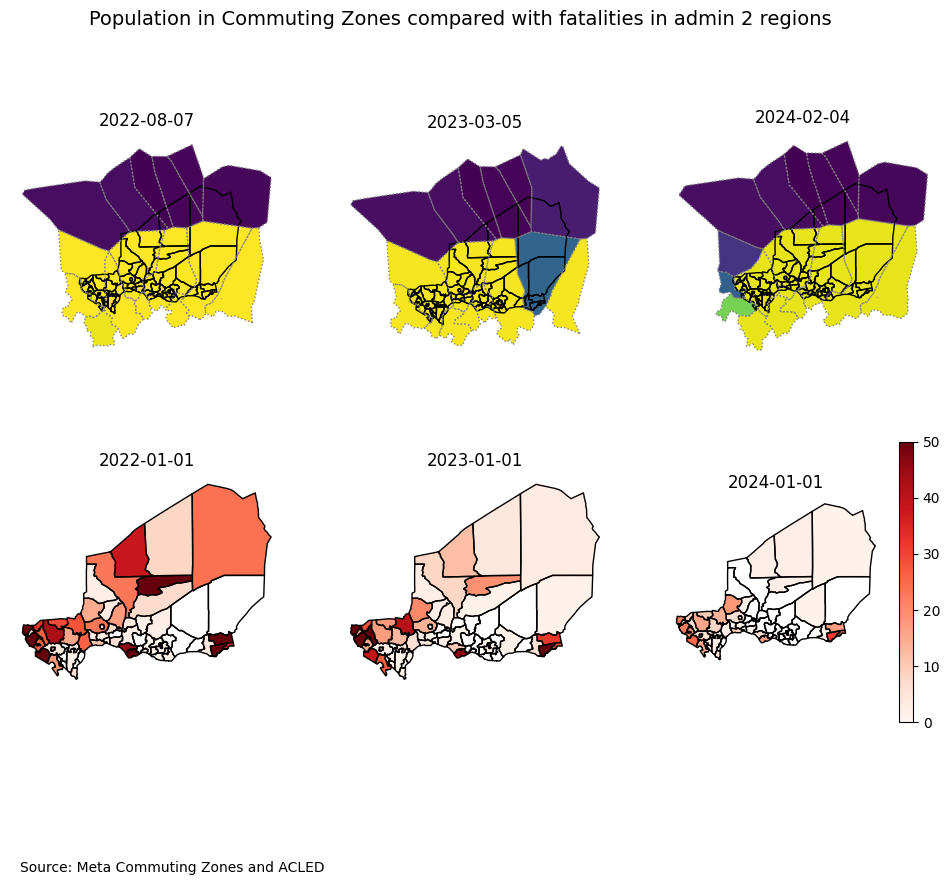

In [88]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
ax = axs.flatten()

for i, date in enumerate(["2022-08-07", "2023-03-05", "2024-02-04"]):
    if i > 4:
        legend_bool = True
    else:
        legend_bool = False

    niger_adm2.boundary.plot(ax=ax[i], color="black", linewidth=1)
    commuting_zones_niger[commuting_zones_niger["ds"] == date].boundary.plot(
        ax=ax[i], color="grey", linewidth=1, linestyle="dotted"
    )
    commuting_zones_niger[commuting_zones_niger["ds"] == date].plot(
        ax=ax[i],
        column="win_population",
        cmap="viridis",
        vmin=0,
        vmax=4500000,
        legend=legend_bool,
    )
    ax[i].set_title(date)

    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].spines["top"].set_visible(False)
    ax[i].spines["bottom"].set_visible(False)
    ax[i].spines["right"].set_visible(False)
    ax[i].spines["left"].set_visible(False)

for idx, date in enumerate(["2022-01-01", "2023-01-01", "2024-01-01"]):
    i = idx + 3

    if i > 4:
        legend_bool = True
    else:
        legend_bool = False

    niger_adm2.boundary.plot(ax=ax[i], color="black", linewidth=1)
    acled_yearly_adm2[acled_yearly_adm2["event_date"] == date].plot(
        ax=ax[i], column="nrEvents", cmap="Reds", vmin=0, vmax=50, legend=legend_bool
    )
    ax[i].set_title(date)

    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].spines["top"].set_visible(False)
    ax[i].spines["bottom"].set_visible(False)
    ax[i].spines["right"].set_visible(False)
    ax[i].spines["left"].set_visible(False)


ax[3].text(0, 0, "Source: Meta Commuting Zones and ACLED")

plt.suptitle(
    "Population in Commuting Zones compared with fatalities in admin 2 regions",
    x=0.5,
    y=1,
    fontsize=14,
);

# fig.savefig('../../docs/images/commuting_zones_population.svg', format='SVG', dpi=300);